# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Импортируем данные из csv в датасет

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Обозреваем данные

In [2]:
print(df.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

Выводим информацию по данным

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В пункте про изучение упоминались гистограммы 

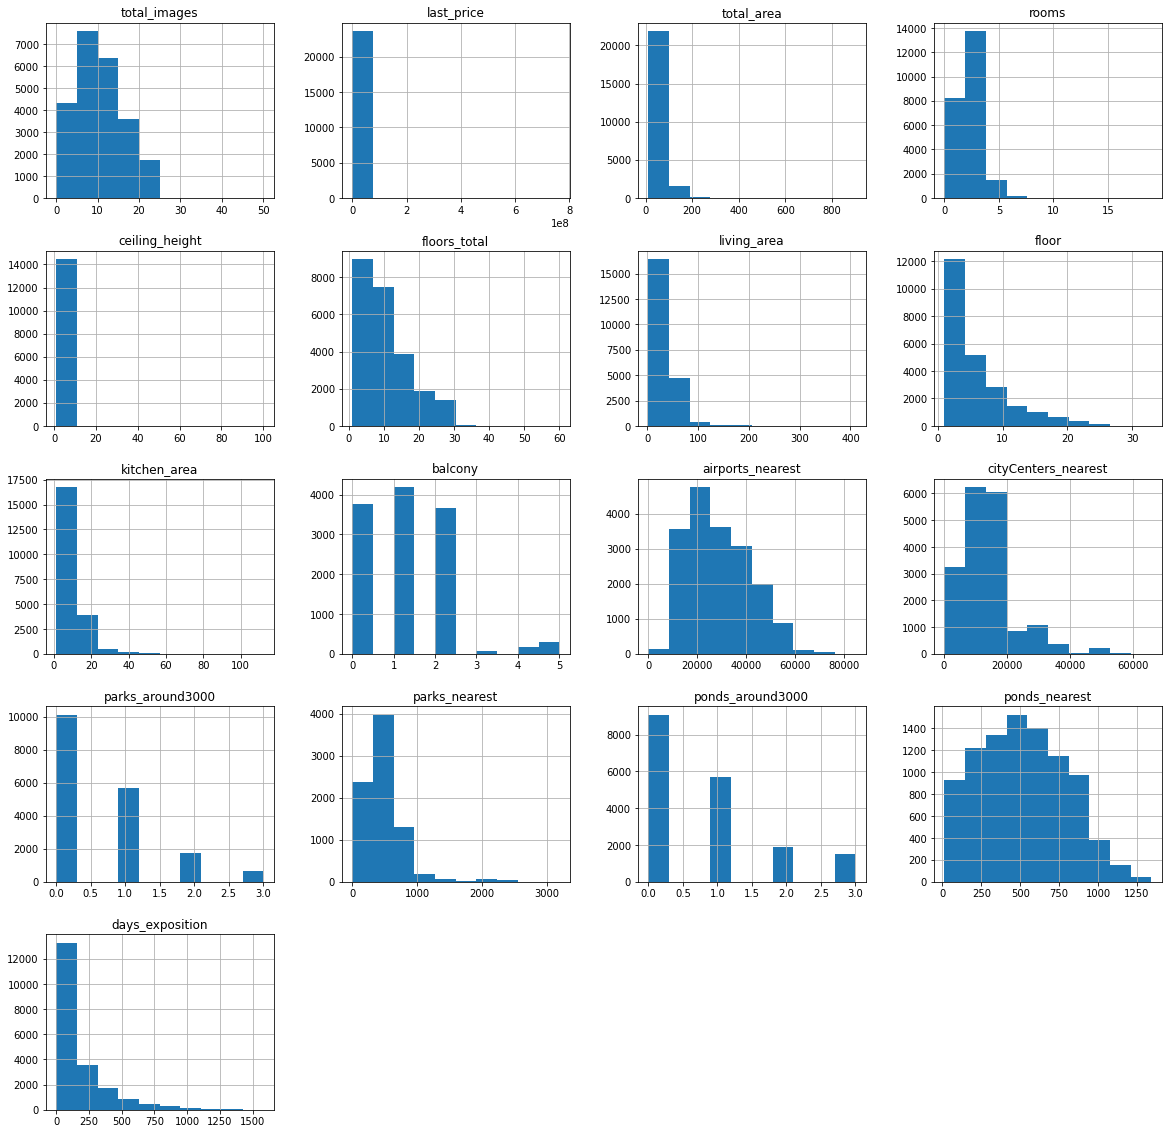

In [4]:
df.hist(figsize=(20, 20));

### Предобработка данных

Переименуем столбец, чтобы все были без верхнего регистра и по красоте

In [5]:
df.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)

**Работа с пропусками**

In [6]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Описание пропущеных значений:**
- **ceiling_height** - высота потолков много где пропущена
- **floors_total** - незаполненных данных немного, на выборку не повлияют, удалим
- **living_area** - жилая площадь не заполнена
- **is_apartment** - предположим что это не апартаменты и заменим на False 
- **kitchen_area** - площадь кухни не заполнена
- **balcony значит** - балкона нет, заменим на 0
- **locality_name** - незаполненных данных немного, на выборку не повлияют, удалим
- **airports_nearest** - аэропортов рядом нет
- **city_centers_nearest** - далеко от центра города
- **parks_around3000** - скорее всего парков в радиусе 3000 метров нет
- **parks_nearest** - скорее всего парков рядом нет
- **ponds_around3000** - скорее всего прудов нет на растоянии 3000 метров
- **ponds_nearest** - прудов рядом нет
- **days_exposition** - скорее всего обьявление не было опубликовано

**Заполнение пропущенных значений:**

Удаляем строки с неопознанным населенным пунктом

In [7]:
df['locality_name'].dropna(inplace=True)

Удаляем строки без определенного количества этажей

In [8]:
df['floors_total'].dropna(inplace=True)

Заменяем в аппартаментах Null на False

In [9]:
df['is_apartment'] = df['is_apartment'].fillna('False')

Заменяем в количестве балконов Null на 0

In [10]:
df['balcony'] = df['balcony'].fillna(0)

**Изменение типов данных:**

- last_price - int64 (целое число)
- first_day_exposition - date (форматы даты)
- floors_total - int64 (целое число)
- is_apartment - bool (работать будет удобнее)
- balcony - int64 (целое число)
- days_exposition - int64 (целое число)

Чтобы выявить ошибки во время изменения данных, будем использовать "try"

In [11]:
try:
    df['last_price'] = df['last_price'].astype('Int64')
    print('last_price_changed')
except:
    print('last_price int type change error')
    
try:    
    df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
    print('first_day_exposition_changed')
except:
    print('first_day_exposition to_datetime type change error')
    
try:
    df['floors_total'] =  df['floors_total'].astype('Int64')
    print('floors_total_changed')
except:
    print('floors_total int64 type change error')
      
try:
    df['is_apartment'] = df['is_apartment'].map({'False':False, 'True':True})
    print('is_apartment_changed')
except:
    print('is_apartment bool type change error')
        
try:
    df['balcony'] = df['balcony'].astype('Int64')
    print('balcony_changed')
except:
    print('balcony int64 type change error')
    
try:
    df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'], errors='coerce')).astype('Int64')
    print('days_exposition_changed')
except:
    print('days_exposition int64 type change error')

last_price_changed
first_day_exposition_changed
floors_total_changed
is_apartment_changed
balcony_changed
days_exposition_changed


Проверим

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  Int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          20924 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Неявные дубликаты в названиях населённых пунктов**

In [13]:
def loc_name():
    return print('Уникальные занчения locality_name:', df['locality_name'].unique().shape[0])
loc_name()

Уникальные занчения locality_name: 365


In [14]:
df['locality_name'] = df['locality_name'].str.lower()

loc_name()

Уникальные занчения locality_name: 365


In [15]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')

loc_name()

Уникальные занчения locality_name: 331


In [16]:
df['locality_name'] = df['locality_name'].str.replace('городской поселок','поселок городского типа')

In [17]:
loc_name()

Уникальные занчения locality_name: 324


In [18]:
print('Количетво явных дубликатов:', df.duplicated().sum())

Количетво явных дубликатов: 0


**Аномальные значения**

In [19]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


С **total_images** все в порядке, идем дальше

**last_price**

- нет бесплатных квартир (0руб.)
- есть квартиры очень дорогие, свыше 100 млн руб., уберем их
- есть квартира очень дешевая, меньше 100 000 руб., уберем ее
- есть квартиры стоимостью меньше 1 млн руб., но но и площадь там 12кв.м., так что похоже на правду

In [20]:
df.drop(index=df.query('last_price < 1e+05').index,inplace=True)
df.drop(index=df.query('last_price > 1e+08').index,inplace=True)

print('Квартир стоит 0 руб.:', df.query('last_price == 0')['last_price'].count())
print('Квартир стоит больше 100 млн руб.:', df.query('last_price > 1e+08')['last_price'].count())
print('Квартир стоит меньше 100 тыс руб.:', df.query('last_price < 1e+05')['last_price'].count())

Квартир стоит 0 руб.: 0
Квартир стоит больше 100 млн руб.: 0
Квартир стоит меньше 100 тыс руб.: 0


**total_area**

Есть квартиры меньше 20 кв.м., такие сдудии вполне возможны.
Но есть квартиры с площадью более 500 кв.м.,их немного, похоже на элитную недвижемость, лучше удалить.

In [21]:
df.drop(index=df.query('total_area > 500').index,inplace=True)

**rooms**

Проверим нулевые значения

In [22]:
print('без комнат:',df.query('rooms == 0')['rooms'].count())

без комнат: 197


Возможно это апартаменты\студии или свободная планировка квартир

In [23]:
print('Пропущенных значений:',df.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())

Пропущенных значений: 0


Также присутствуют квартиры ну с очень большим количеством комнат, что маловероятно, так что удалим все больше 7 комнат (начиная от 7 комнат количествор таких квартир значительно падает)

In [24]:
df.drop(index=df.query('rooms > 7').index,inplace=True)

**ceiling_height**

Высота от потолка до пола в РФ регламентируется в соответствии со СНиПом от 2003 года и = 2.5-3.6 метра (поиск Яндекс)

In [25]:
print('Квартиры с потолками меньше 2.5м:', df.query('ceiling_height > 0 and ceiling_height < 2.5')['ceiling_height'].count())
print('Квартиры с потолками от 2.5 до 4м:', df.query('ceiling_height > 2.5 and ceiling_height <= 4')['ceiling_height'].count())
print('Квартиры с потолками от 4 до 5м:', df.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count())
print('Квартиры с потолками от 5 до 25м:', df.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count())
print('Квартиры с потолками от 25м до 36м:', df.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count())
print('Квартиры с потолками от 36м до 50м:', df.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count())
print('Квартиры с потолками от 50м:', df.query('ceiling_height >= 50')['ceiling_height'].count())

Квартиры с потолками меньше 2.5м: 73
Квартиры с потолками от 2.5 до 4м: 10800
Квартиры с потолками от 4 до 5м: 36
Квартиры с потолками от 5 до 25м: 14
Квартиры с потолками от 25м до 36м: 19
Квартиры с потолками от 36м до 50м: 0
Квартиры с потолками от 50м: 1


Квартиры с потолками меньше 2.5м - не подходят в соответствии со СНиПом

Квартиры с потолками от 2.5 до 4м - норма

Квартиры с потолками от 4 до 5м - маловероятно

Квартиры с потолками от 5 до 25м - такого не может быть 

Квартиры с потолками от 25м до 36м - это оппечатки, скорее всего пропущен разделитель

Квартиры с потолками от 36м до 50м - это выброс 

Квартиры с потолками от 50м - тоже выброс

In [26]:
df.drop(index=df.query('ceiling_height < 2.5').index,inplace=True)

df.drop(index=df.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)

df.update(df[(df['ceiling_height'] >= 25) & (df['ceiling_height'] <= 36)]['ceiling_height']/10)

df.drop(index=df.query('ceiling_height > 36').index,inplace=True)

In [27]:
print('Квартиры с потолками меньше 2.5м:', df.query('ceiling_height > 0 and ceiling_height < 2.5')['ceiling_height'].count())
print('Квартиры с потолками от 2.5 до 4м:', df.query('ceiling_height > 2.5 and ceiling_height <= 4')['ceiling_height'].count())
print('Квартиры с потолками от 4 до 5м:', df.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count())
print('Квартиры с потолками от 5 до 25м:', df.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count())
print('Квартиры с потолками от 25м до 36м:', df.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count())
print('Квартиры с потолками от 36м до 50м:', df.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count())
print('Квартиры с потолками от 50м:', df.query('ceiling_height >= 50')['ceiling_height'].count())

Квартиры с потолками меньше 2.5м: 0
Квартиры с потолками от 2.5 до 4м: 10812
Квартиры с потолками от 4 до 5м: 0
Квартиры с потолками от 5 до 25м: 0
Квартиры с потолками от 25м до 36м: 0
Квартиры с потолками от 36м до 50м: 0
Квартиры с потолками от 50м: 0


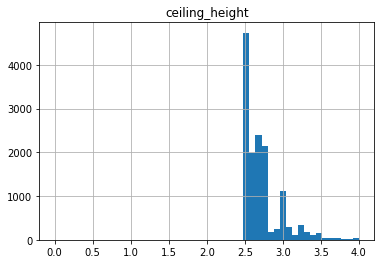

In [67]:
df.hist('ceiling_height',bins=50,range=(0,4));

В основном квартиры с потолками 2.5 метра

**floors_total**

In [30]:
print('Квартиры в одноэтажных домах:', df.query('floors_total == 1')['floors_total'].count())
print('Квартиры в домах до 10 этажей:', df.query('floors_total > 1 and floors_total <= 10')['floors_total'].count())
print('Квартиры в домах от 10 до 20 этажей:', df.query('floors_total > 10 and floors_total <= 20')['floors_total'].count())
print('Квартиры в домах от 30 этажей:', df.query('floors_total > 30')['floors_total'].count())

Квартиры в одноэтажных домах: 23
Квартиры в домах до 10 этажей: 14704
Квартиры в домах от 10 до 20 этажей: 6016
Квартиры в домах от 30 этажей: 31


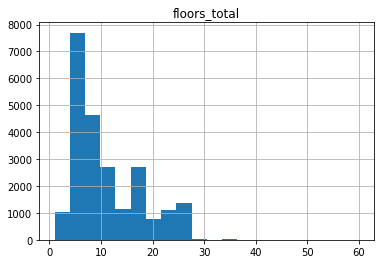

In [68]:
df.hist('floors_total', bins=20);

Данные похожи на правду

**living_area**

В среднем квартиры от 10 до 60 кв.м. 

Встречаются мельше 10 и квартиры больше 200 кв.м., но это или аномалии или опечатки 

Избавимся от аномалий

In [33]:
df.drop(index=df.query('living_area < 10').index,inplace=True)
df.drop(index=df.query('living_area > 200').index,inplace=True)

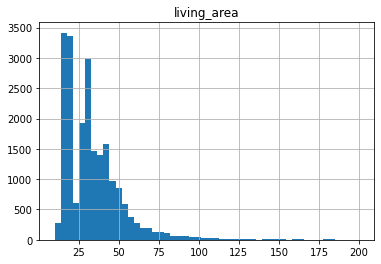

In [69]:
df.hist('living_area', bins=50);

**floor**

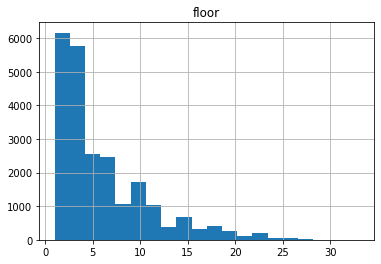

In [70]:
df.hist('floor',bins=20);

Нулевых этажей нет, с данными все в порядке, в основном это малоэтажная застройка

**kitchen_area**

Самая маленькая кухня меньше 2 кв.м. - это аномалия или оппечатка

Самая большая 112 кв.м.

Удалим данные меньше 2х квадратов и больше 50

In [36]:
df.drop(index=df.query('kitchen_area < 2').index,inplace=True)
df.drop(index=df.query('kitchen_area > 50').index,inplace=True)

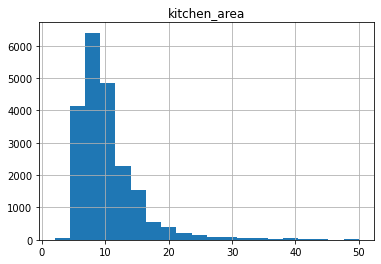

In [71]:
df.hist('kitchen_area',bins=20);

**balcony**

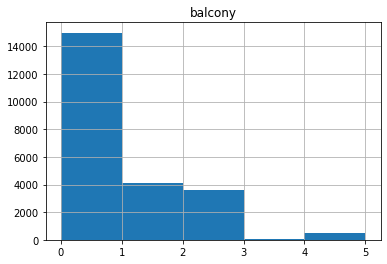

In [72]:
df.hist('balcony',bins=5);

Количество балконов выглядит правдоподобно

**days_exposition**

In [40]:
print('Объявлению меньше года: ',df.query('days_exposition < 365')['days_exposition'].count())
print('Объявлению больше года: ',df.query('days_exposition > 365 and days_exposition < 365*2')['days_exposition'].count())
print('Объявлению больше 2 лет: ',df.query('days_exposition > 365*2 and days_exposition < 365*3')['days_exposition'].count())
print('Объявлению больше 3 лет: ',df.query('days_exposition > 365*3')['days_exposition'].count())

Объявлению меньше года:  17284
Объявлению больше года:  2259
Объявлению больше 2 лет:  565
Объявлению больше 3 лет:  165


Объявления, которым больше 3 лет - аномалия, избавимся

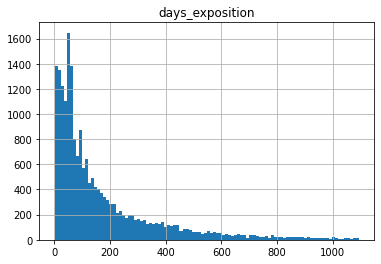

In [41]:
df.drop(index=df.query('days_exposition > 365*3').index,inplace=True)

df.hist('days_exposition', bins=100);

**airports_nearest**

Из выборки выбивается квартира ну очень близко к аэропорту, такое маловероятно

In [43]:
df.drop(index=df.query('airports_nearest < 5000').index,inplace=True)

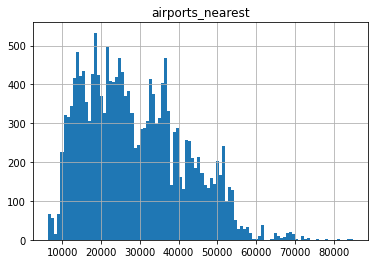

In [44]:
df.hist('airports_nearest', bins=100);

Исходя из первоначальных гистограм оставшиеся столбцы выглядят правдоподобно, аномальных значений нет

На всякий случай сбросим индексацию после предобработки данных

In [45]:
df.reset_index(drop=True,inplace=True)

**Выводы (предобработка данных)**

Предобработка данных потребовала: 
- привести названия к нижнему регистру
- избавится от пропусков, где это возможно
- избавится от ивных и неявных дубликатов
- избавится от маловероятных аномальных значений (выбросов)
- сбросить индексацию базы данных

Итого: Работать с данной таблицей можно, и в дальнейшем проводить исследовательский анализ данных.

### Посчитайте и добавьте в таблицу новые столбцы

**Цена одного квадратного метра**

In [46]:
df['cost_per_m'] = df['last_price'] / df['total_area']

**День публикации объявления**

In [47]:
df['day_of_week'] = df['first_day_exposition'].dt.dayofweek

**Месяц публикации объявления**

In [48]:
df['month'] = df['first_day_exposition'].dt.month

**Год публикации объявления**

In [49]:
df['year'] = df['first_day_exposition'].dt.year

**Тип этажа квартиры**

In [50]:
df['floor_category'] = df.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

In [51]:
df['floor_category'].value_counts()

другой       17157
последний     3242
первый        2870
Name: floor_category, dtype: int64

Расстояние в км до центра города

In [52]:
df['city_centers_nearest_km'] = round(df['city_centers_nearest'] / 1000)
try:
    df['city_centers_nearest_km'] =  df['city_centers_nearest_km'].astype('Int32')
    print('city_centers_nearest_km: type change')
except:
    print('city_centers_nearest_km type change error')

city_centers_nearest_km: type change


### Проведите исследовательский анализ данных

Выводим получившуюся инвормацию:
- обновленный df
- гистограммы

**Оновленные параметры**

In [53]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_m,day_of_week,month,year,city_centers_nearest_km
count,23269.000000,2.326900e+04,23269.000000,23269.000000,14161.000000,23185.000000,21398.000000,23269.000000,21029.000000,23269.000000,...,17811.000000,7853.000000,17811.000000,8877.000000,20129.000000,23269.000000,23269.000000,23269.000000,23269.000000,17810.000000
mean,9.861876,6.108890e+06,59.077140,2.048004,2.718538,10.711063,33.750936,5.904078,10.375841,0.592075,...,0.603503,490.491023,0.762506,520.325898,171.424164,98191.449578,2.572607,6.399630,2017.386867,14.261426
std,5.674370,5.925284e+06,30.361778,1.020323,0.252113,6.604607,19.139593,4.892588,5.116384,0.959019,...,0.795832,340.128745,0.932759,277.843231,197.202647,42180.520133,1.789443,3.487328,1.020240,8.585143
min,0.000000,4.300000e+05,12.000000,0.000000,2.500000,1.000000,10.000000,1.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,13.000000,1.000000,7962.962963,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,...,0.000000,288.000000,0.000000,297.000000,44.000000,76517.150396,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.050000,0.000000,...,0.000000,455.000000,0.000000,504.000000,93.000000,94818.652850,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.800000,16.000000,42.000000,8.000000,12.000000,1.000000,...,1.000000,612.000000,1.000000,733.000000,224.000000,113772.455090,4.000000,10.000000,2018.000000,16.000000
max,50.000000,9.900000e+07,494.100000,7.000000,4.000000,60.000000,200.000000,33.000000,50.000000,5.000000,...,3.000000,3190.000000,3.000000,1344.000000,1095.000000,848484.848485,6.000000,12.000000,2019.000000,66.000000


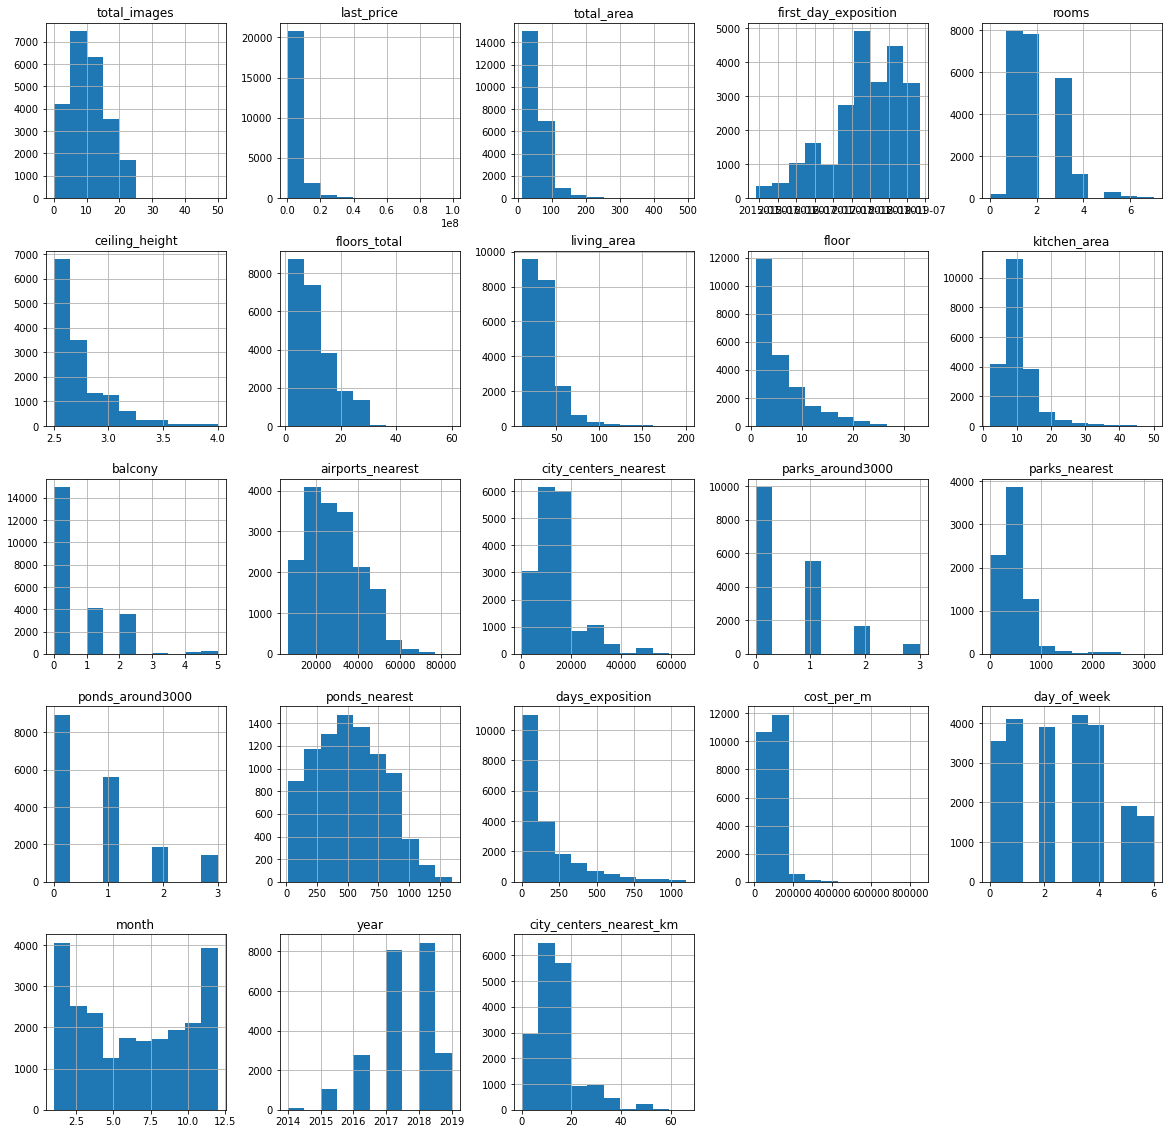

In [73]:
df.hist(figsize=(20, 20));

**Гистограммы**

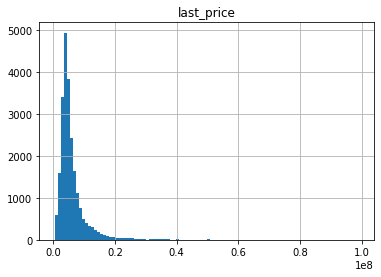

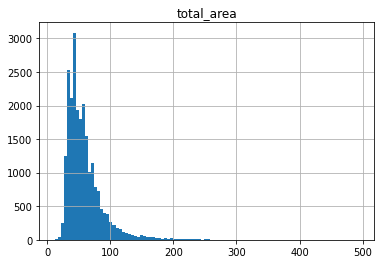

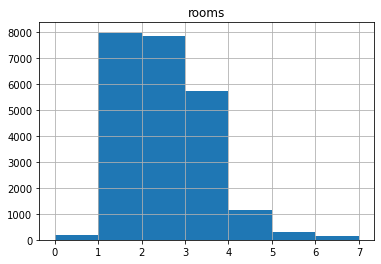

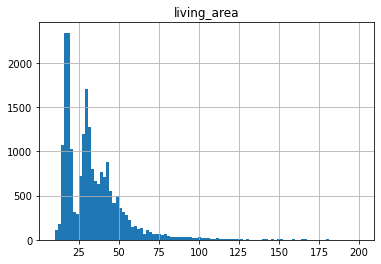

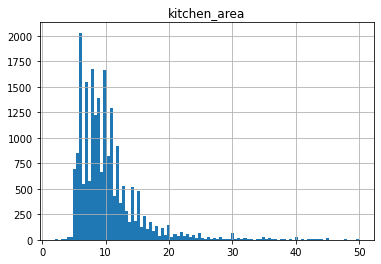

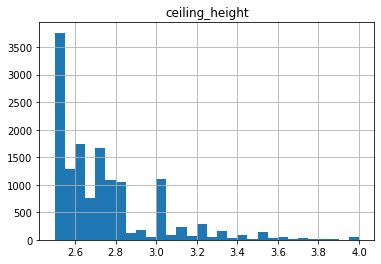

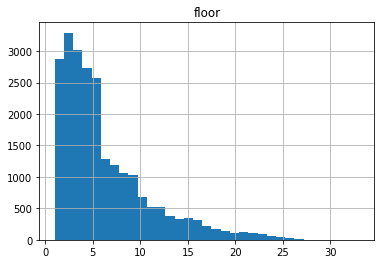

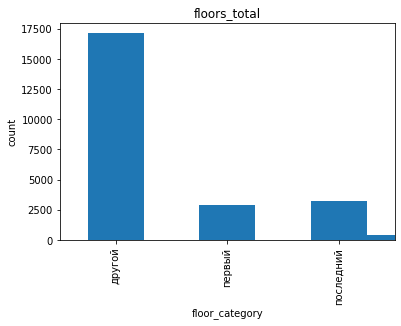

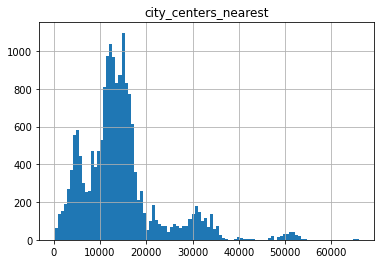

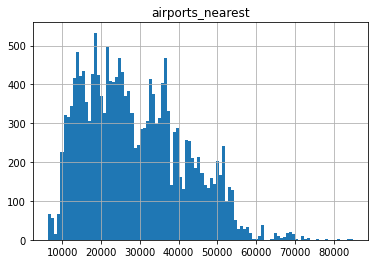

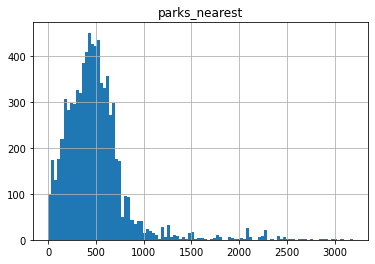

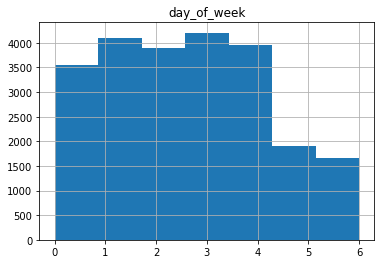

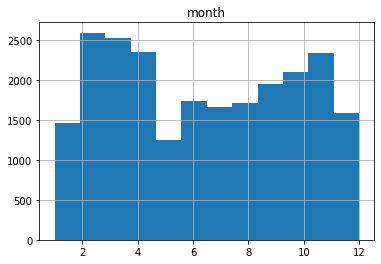

In [55]:
df.hist('last_price', bins=100);

df.hist('total_area', bins=100);

df.hist('rooms', bins=df['rooms'].max());

df.hist('living_area', bins=100);

df.hist('kitchen_area', bins=100);

df.hist('ceiling_height', bins=30);

df.hist('floor', bins=df['floor'].max());

df.hist('floors_total', bins=df['floors_total'].max());

df.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');

df.hist('city_centers_nearest', bins=100);

df.hist('airports_nearest', bins=100);

df.hist('parks_nearest', bins=100);

df.hist('day_of_week', bins=7);

df.hist('month', bins=12);

**Построили гистограммы для следующих параметров:**

**Цена объекта**
Цены квартир выглядят хорошо, вправо уходит ухвост, но это цены "элитная недвижимость".

**Общая площадь**
Предобладают квартиры с небольшой общей площадью.

**Количество комнат**
Больше всего 2х и 3х комнатных квартир.

**Жилая площадь**
На графике видны два пика - на 18 кв.м. и на 30 кв.м, предположительно это студии/однушки и 2-3 комнатные квартины.

**Площадь кухни**
Площадь кухни выглядит хорошо.

**Высота потолков**
На графике видны два пика 2.5м. и 3м., согласно стандартам.

**Этаж квартиры**
Больше всего квартир с 1 по 5 этаж.

**Общее количество этажей в доме**
На графике видны два пика 5-этажки и 9-этажки.

**Тип этажа квартиры («первый», «последний», «другой»)**
Первых и последних этажей мало. Основная часть находится на "другом" этаже.

**Расстояние до центра города в метрах**
На графике видны два пика, поменьше на 5км. и побольше на 10-15 км.

**Расстояние до ближайшего аэропорта**
Выглядит нормально, недвижимость расположена на разных растояниях от аэропорта, от этого видно "шум"

**Расстояние до ближайшего парка**
На графике видно, что больше всего квартир (с парками) на расстоянии до 750м.

**День и месяц публикации объявления**
В субботу и воскресенье провалы в графике, выходные. По месяцам видны провалы в декабре, январе и мае, что соответстует продолжительным праздникам

**Как быстро продавались квартиры**

Строим гистограмму

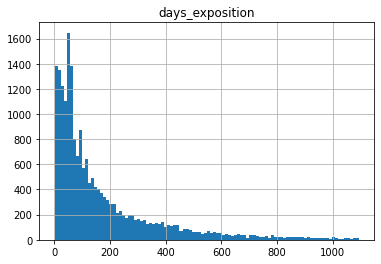

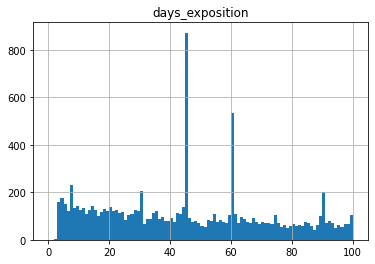

In [85]:
df.hist('days_exposition', bins=100);
df.hist('days_exposition', bins=100, range = (0,100));

Считаем среднее и медиану

Среднее время продажи квартиры в днях: 171
Медианное время продажи квартиры в днях: 93


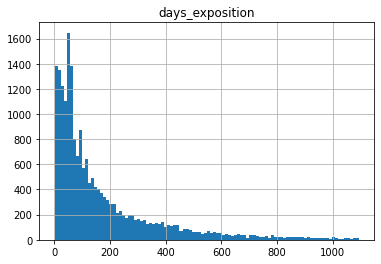

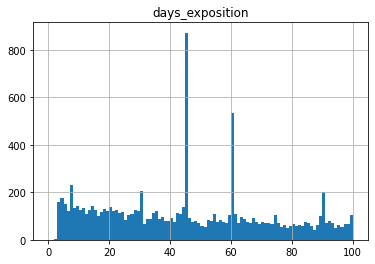

In [81]:
df.hist('days_exposition', bins=100);
df.hist('days_exposition', bins=100, range = (0,100));
print(f'Среднее время продажи квартиры в днях:',int(df['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(df['days_exposition'].median()))

In [86]:
print('Количество объявлений, которые сняты через:')
print('45 дней:',df[df['days_exposition']==45]['days_exposition'].count())
print('60 дней:',df[df['days_exposition']==60]['days_exposition'].count())
print('90 дней:',df[df['days_exposition']==90]['days_exposition'].count())

Количество объявлений, которые сняты через:
45 дней: 872
60 дней: 535
90 дней: 202


Выбросы происходят в конкретные дни, что похоже на истекший срок размещения платных обьявлений

Быстрыми продажами можно считать сроки до 93 дней, а необычно долгими - свыше 171 дня. Такое среднее обучловлено тем, что есть длинный хвост из обектов, которые продаются годами. 

**Какие факторы больше всего влияют на общую (полную) стоимость объекта**

Считаем корреляцию от:
- общей площади;
- жилой площади;
- площади кухни;
- количество комнат;
- типа этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год);

**Зависимость стоимости от общей площади**

Корреляция цены и общей площади:
            last_price  total_area
last_price    1.000000    0.880516
total_area    0.880516    1.000000


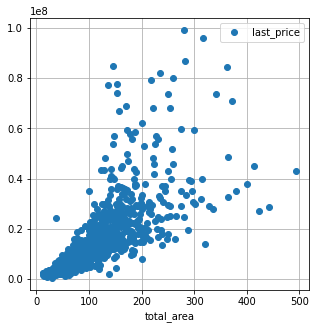

In [58]:
(
    df.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
print('Корреляция цены и общей площади:')
print(df.pivot_table(index='floor', values=['total_area', 'last_price']).corr())

**Зависимость стоимости от жилой площади**

Корреляция цены и жилой площади:
             last_price  living_area
last_price     1.000000     0.742089
living_area    0.742089     1.000000


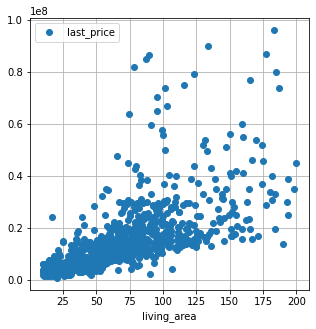

In [59]:
(
    df.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
print('Корреляция цены и жилой площади:')
print(df.pivot_table(index='floor', values=['living_area', 'last_price']).corr())

**Зависимость стоимости от площади кухни**

Корреляция цены и площади кухни:
              kitchen_area  last_price
kitchen_area      1.000000    0.342623
last_price        0.342623    1.000000


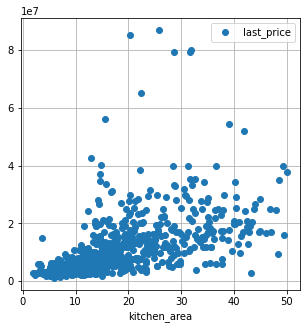

In [60]:
(
    df.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
print('Корреляция цены и площади кухни:')
print(df.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr())

**Зависимость стоимости от количества комнат**

Корреляция цены и числа комнат:
            last_price     rooms
last_price    1.000000  0.591432
rooms         0.591432  1.000000


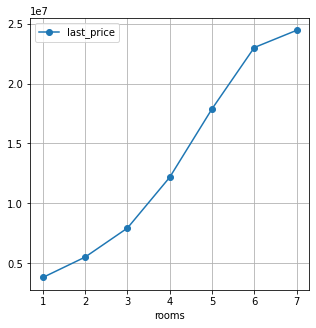

In [61]:
(
    df.query('rooms > 0').pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
print('Корреляция цены и числа комнат:')
print(df.query('rooms > 0').pivot_table(index='floor', values=['rooms', 'last_price']).corr())

**Зависимость стоимости от этажа**

Корреляция цены и этажа:
            last_price
last_price         1.0


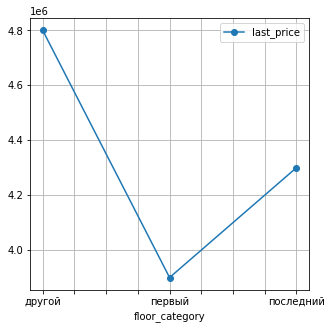

In [62]:
(
    df.pivot_table(index='floor_category', values='last_price', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
print('Корреляция цены и этажа:')
print(df.pivot_table(index='floor', values=['floor_category', 'last_price']).corr())

**Зависимость стоимости от публикации**

Корреляция цены и дня публикации:
             day_of_week  last_price
day_of_week     1.000000    0.463771
last_price      0.463771    1.000000


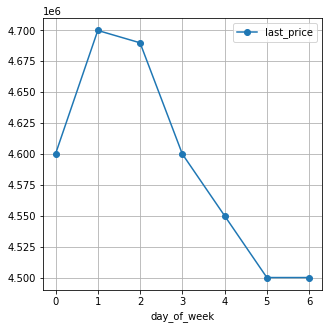

In [77]:
(
    df.pivot_table(index='day_of_week', values='last_price', aggfunc='median')
    .plot(grid=True, style='-o', figsize=(5, 5))
)
print('Корреляция цены и дня публикации:')
print(df.pivot_table(index='floor', values=['day_of_week', 'last_price']).corr())

Корреляция цены и месяца публикации:
            last_price     month
last_price    1.000000 -0.010403
month        -0.010403  1.000000


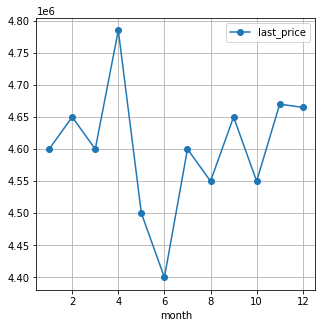

In [78]:
(
    df.pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(grid=True, style='-o', figsize=(5, 5))
)
print('Корреляция цены и месяца публикации:')
print(df.pivot_table(index='floor', values=['month', 'last_price']).corr())

Корреляция цены и года публикации:
            last_price      year
last_price    1.000000  0.053126
year          0.053126  1.000000


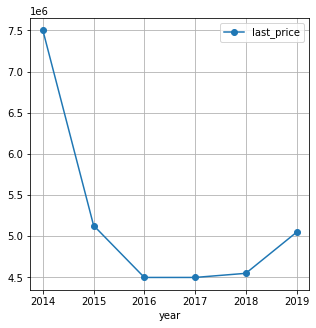

In [79]:
(
    df.pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(grid=True, style='-o', figsize=(5, 5))
)
print('Корреляция цены и года публикации:')
print(df.pivot_table(index='floor', values=['year', 'last_price']).corr())

**Вывод**

- Чем больше общая, жилая и площадь кухни, чем больше комнат, тем выше стоимость обьекта. Высокая зависимость
- Число комнат также влияет на стоимость, чем больше комнат, тем больше цена. Зависимость меньше, чем от площади.
- Квартиры на первом и последнем этаже стоят дешевле
- Размещение обьявления не влияет на стоимость 

**Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах**

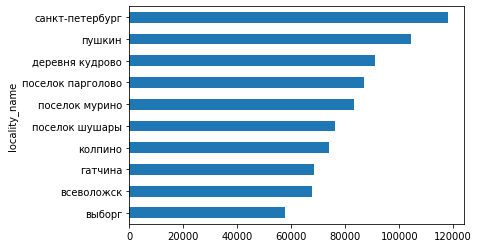

In [74]:
loc_10 = df.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
loc_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
loc_10.pop('total_area_count')
loc_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
loc_10 = loc_10.iloc[:10]
loc_10['price_per_m'] = loc_10['last_price_sum']/loc_10['total_area_sum']
loc_10.sort_values(by=['price_per_m'],ascending=True, inplace=True)
loc_10['price_per_m'].plot(kind='barh');

In [65]:
df.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
санкт-петербург,15386,5500000.0
поселок мурино,553,3400000.0
поселок шушары,438,3950000.0
всеволожск,394,3490000.0
пушкин,357,5150000.0
колпино,335,3600000.0
поселок парголово,325,4100000.0
гатчина,307,3100000.0
деревня кудрово,298,3785000.0


**Вывод**

Самая дорогая недвижимость в СПБ, в топ 10 входят приближенные к нему города

**Цена от центра города**

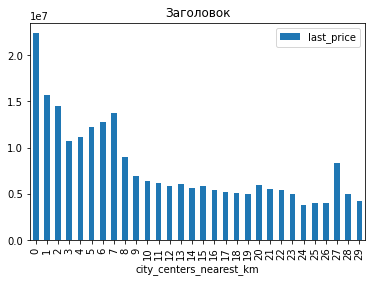

In [66]:
(
    df[df['locality_name']=='санкт-петербург']
    .pivot_table(
        index='city_centers_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar', title = 'Заголовок')
);

**Вывод**

- Самые дорогие обьекты находятся на растоянии до 1км.
- Высокие цены на расстоянии от 1 до 7 км., начиная с 8 км. цена снижается на расстояние до 27 км.
- На 27км. выброс, скорее всего элитная недвижимость

### Общий вывод

Предобработка данных потребовала потребовала разобраться с пропущеными значениями, убрать или замениить их. 

Работать с подобной таблицей можно, но лучше сперва избавится от сильных "вибросов", а также явных и неявных дубликатов, что в дальнейшем позволит проводить более качественный исследовательский анализ данных. 

Основываясь на полученных данных можно сказать:
- Цена в основном зависит от площади квартиры
- Цены на первом и последнем этажах ниже
- Самые дорогие квартиры в Санкт-Петербурге, а самые дешевые в Выборге
- В СПБ самые дорогие квартиры находятся на растоянии 7км. от центра
- Быстрыми продажами можно считать сроки до 93 дней, а необычно долгими - свыше 171 дня


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод